## 1.导入包

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']    # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False           # 解决保存图像是负号'-'显示为方块的问题

## 2.读取数据

In [4]:
df = pd.read_excel(r"D:\Dijkstra\附件2：数据集2-终稿.xlsx",header=1,index_col=0)

## 3.数据预处理

In [5]:
df1 = df
print(df1)
n = df1.shape[0]-1
df1.loc[0, '校正点类型'] = 2  # A点用2表示
df1.loc[n, '校正点类型'] = 3  # B点用3表示
data = np.array(df1.values)

        X坐标（单位: m）    Y坐标（单位: m）   Z坐标（单位: m） 校正点类型  第三问点标记
编号                                                         
0         0.000000  50000.000000  5000.000000    A点       0
1     76009.848438   9788.111546  9121.895312     1       0
2      2448.199054  71599.875612  1877.128662     0       0
3     27800.929067  15218.071945  8345.410372     0       0
4     50056.728450  91668.088891  1465.092302     0       0
..             ...           ...          ...   ...     ...
322    7946.309207  39584.641077  5737.066682     1       0
323   78846.702215  73662.651583  3906.982043     1       0
324   63645.559992  71435.222715  6263.129062     0       1
325   19134.855718  85017.867083  2434.512879     0       0
326  100000.000000  74860.548900  5499.611095    B点       0

[327 rows x 5 columns]


## 4.生成三维散点图

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_10052/2098187255.py:21: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


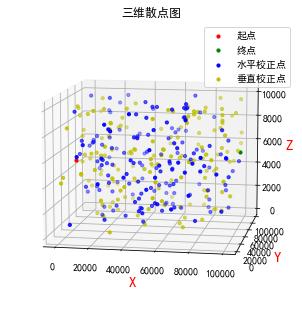

In [6]:
def generate_3D_scatter(data):
    #### 起点 ####
    Xa = data[0][0]
    Ya = data[0][1]
    Za = data[0][2]
    #### 终点 ####
    Xb = data[n][0]
    Yb = data[n][1]
    Zb = data[n][2]
    #### 水平校正点 ####
    Xh = data[data[:,3]==0][:,0]
    Yh = data[data[:,3]==0][:,1]
    Zh = data[data[:,3]==0][:,2]
    #### 垂直校正点 ####
    Xv = data[data[:,3]==1][:,0]
    Yv = data[data[:,3]==1][:,1]
    Zv = data[data[:,3]==1][:,2]

    #### 绘制三维散点图 ####
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(Xa,Ya,Za, c='r', s=10, label='起点')
    ax.scatter(Xb,Yb,Zb, c='g', s=10, label='终点')
    ax.scatter(Xh,Yh,Zh, c='b', s=10, label='水平校正点')
    ax.scatter(Xv,Yv,Zv, c='y', s=10, label='垂直校正点')

    # 绘制图例
    ax.legend(loc='best')

    # 添加坐标轴(顺序是Z, Y, X)
    ax.set_zlabel('Z', fontdict={'size': 15, 'color': 'red'})
    ax.set_ylabel('Y', fontdict={'size': 15, 'color': 'red'})
    ax.set_xlabel('X', fontdict={'size': 15, 'color': 'red'})

    ax.view_init(elev=10., azim=-80)
    # 展示
    plt.title("三维散点图")
    plt.show()
generate_3D_scatter(data)

## 5.生成距离矩阵

In [7]:
# 问题2：α1 = 20，α2 = 10，β1 = 15，β2 = 20，𝜃 = 20，𝛿 = 0.001
##计算两点之间的欧式距离
def cal_distance(point1,point2):
    return np.linalg.norm(point1 - point2)
##建立距离矩阵
##根据第一问要求可以得到 当垂直-水平校正交替的情况下能够获得最优航迹路径；
def build_distance_matrix(data, delta, limit):
    n = len(data)
    mat = np.zeros([n,n])
    for i in range(0,n):
        point1 = data[i,0:3]
        attr1 = data[i,3]
        for j in range(0,n):
            if j != i:
                point2 = data[j,0:3]
                attr2 = data[j, 3]
                dis = cal_distance(point1,point2)
                #如果连续两个水平校正点或连续两个垂直校正点，则把两点之间的距离设为无穷大
                if attr1==0 and attr2 ==0:
                    mat[i][j] = float('inf')
                elif attr1==1 and attr2==1:
                    mat[i][j] = float('inf')
                else:
                    if dis * delta <= limit:
                        mat[i][j] = dis
                    #如果两点之间的误差大于α2，β1时无法进行任何校正
                    else:
                        mat[i][j] = float('inf')
    return mat
dis_mat = build_distance_matrix(data,0.001,15)
dis_mat

array([[ 0., inf, inf, ..., inf, inf, inf],
       [inf,  0., inf, ..., inf, inf, inf],
       [inf, inf,  0., ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ...,  0., inf, inf],
       [inf, inf, inf, ..., inf,  0., inf],
       [inf, inf, inf, ..., inf, inf,  0.]])

## 6.带约束的Dijkstra算法

In [8]:
def dijkstra(start, point_type, graph, alpha1, alpha2, beta1, beta2, theta, delta):
    '''
    :param start: 起点下标
    :param point_type: 点的类型：水平校正点为0，垂直校正点为1，起点为2，终点为3
    :param graph: 距离矩阵
    :return:
            dist: 到达每个节点的最短路径列表
            pre_node_list: 前驱节点列表
            node_num_list: 到达每个点需要经过的节点个数
            h_error:水平误差
            v_error:垂直误差
    '''
    if graph is None:
        return None
    #到达每个节点的最短距离向量
    dist = [float("inf")] * len(graph)
    dist[start] = 0
    # 水平误差
    h_error = [float("inf")] * len(graph)
    h_error[start] = 0
    # 垂直误差
    v_error = [float("inf")] * len(graph)
    v_error[start] = 0
    #访问过的节点列表
    S = []
    #未访问过的节点列表
    Q = [x for x in range(len(graph))]
    #初始节点与其他节点的距离
    dis_list = [i for i in graph[start]]
    #前驱节点列表
    pre_node_list = [float("inf")] * len(graph)
    #到达每个节点需要经过的节点数量
    node_num_list = [float("inf")] * len(graph)
    node_num_list[start] = 0
    while Q:
        #找出初始节点与其他节点的最近距离且该节点必须在未访问的节点列表中
        u_dist = min([d for v, d in enumerate(dis_list) if v in Q])
        if u_dist == float("inf"):
            break
        #求出该点下标
        u = dis_list.index(u_dist)
        #将u节点添加到访问过的节点列表
        S.append(u)
        #将u节点移出未访问过的节点列表
        Q.remove(u)
        #寻找u的下一个节点v
        for v,d in enumerate(graph[u]):
            if d != float("inf"):
                #如果起点到v的距离大于起点到u的距离才需要更新，否则保持
                if dist[v] > dist[u] + d:
                    #如果v点为水平校正点
                    if point_type[v] == 0 and h_error[u] + d * delta < beta2 and v_error[u] + d * delta < beta1:
                        #清空水平误差
                        h_error[v] = 0
                        #对到v点的距离进行赋值
                        dist[v] = dist[u] + d
                        dis_list[v] = dist[v]
                        #更新垂直误差
                        v_error[v] = v_error[u] + d*delta
                        #更新前驱节点列表
                        pre_node_list[v] = u
                        #更新到达每个节点需要经过的节点数量
                        node_num_list[v] = node_num_list[u] + 1
                    # 如果v点为垂直校正点
                    if point_type[v] == 1 and h_error[u] + d * delta < alpha2 and v_error[u] + d * delta < alpha1:
                        #清空垂直误差
                        v_error[v] = 0
                        #对到v点的距离进行赋值v
                        dist[v] = dist[u] + d
                        dis_list[v] = dist[v]
                        #更新垂直误差
                        h_error[v] = h_error[u] + d*delta
                        #更新前驱节点列表
                        pre_node_list[v] = u
                        #更新到达每个节点需要经过的节点数量
                        node_num_list[v] = node_num_list[u] + 1
                    # 如果v点为终点
                    if point_type[v] == 3 and h_error[u] + d * delta < theta and v_error[u] + d * delta < theta:
                        #更新水平误差
                        h_error[v] = h_error[u] + d*delta
                        #更新垂直误差
                        v_error[v] = v_error[u] + d*delta
                        #对到v点的距离进行赋值v
                        dist[v] = dist[u] + d
                        #更新前驱节点列表
                        pre_node_list[v] = u
                        #更新到达每个节点需要经过的节点数量
                        node_num_list[v] = node_num_list[u] + 1

    return dist, pre_node_list, node_num_list,h_error,v_error
dist, pre_node_list, node_num_list,h_error,v_error = dijkstra(start=0,point_type=data[:,3],graph=dis_mat,alpha1=20,alpha2=10,beta1=15,beta2=20,theta=20,delta=0.001)
print("到达每个节点的最短路径列表:",dist)
print("="*120)
print("前驱节点列表：",pre_node_list)
print("="*120)
print("到达每个点需要经过的节点个数:",node_num_list)
print("水平误差：",h_error)
print("垂直误差：",v_error)

到达每个节点的最短路径列表: [0, 98108.69242545142, 27375.152834449873, 53818.694487503206, 89288.32544814414, 27259.967276794978, 79343.65322470378, 72751.53616180236, 32544.03671238354, 72619.00318212106, 28824.64901817879, 121451.0455855286, 90018.44203727011, 80270.10473516906, 68209.50870193857, 95852.98913568229, 101196.49074039646, 119274.7600568555, 85273.4219702741, 82518.34677805805, 110837.56271775947, 90878.56619580417, 116884.44897081249, 79839.35725669803, 60943.657866793445, 95013.56416149551, 70090.22115834341, 92179.11870005373, 78274.70671696494, 82912.85104328075, 60137.37704307352, 27846.31390960805, 93992.9048565258, 80429.37090519382, inf, 89183.6699356015, 53872.773591067795, inf, 93720.71528155591, 89065.33705643995, 26424.472211273587, 73243.73766055662, 74933.0041484218, 87671.41013719013, 81101.3259799135, 64678.166420374626, 65872.6433117508, 52594.527324253715, 27605.176869080926, 66462.19945932648, 90144.85203117249, 89474.9776497887, 63907.96529071513, 57233.9059751782

## 7.生成最优路径和最短距离

In [9]:
def generate_path(pre_node_list,last):
    path = [last]
    temp = last
    while temp != 0:
        index = pre_node_list[temp]
        path.append(index)
        temp = index
    return list(reversed(path))
path = generate_path(pre_node_list,last=len(data)-1)
print("最优路径：",path)
print("到达终点的最短距离：",dist[n])

最优路径： [0, 163, 114, 8, 309, 121, 123, 45, 160, 92, 93, 61, 292, 326]
到达终点的最短距离： 110772.81584923199


## 8.到达矫正点之前的误差

In [10]:
def generate_error(path,h_error,v_error):
    h_err = [0]
    v_err = [0]
    for index in range(1,len(path)):
        if h_error[path[index]]==0:
            h_err.append(h_error[path[index-1]]+v_error[path[index]])
        else:
            h_err.append(h_error[path[index]])
        if v_error[path[index]]==0:
            v_err.append(v_error[path[index-1]]+h_error[path[index]])
        else:
            v_err.append(v_error[path[index]])
    return h_err,v_err
h_err,v_err = generate_error(path,h_error,v_error)
print("矫正前的水平误差：",h_err)
print("矫正前的垂直误差：",v_err)

矫正前的水平误差： [0, 13.287897610451276, 5.334153323965658, 19.256139101932263, 5.5243254013786816, 16.776368046351646, 5.3516002441665425, 15.357761661639445, 7.48513454729585, 13.261298172654595, 9.484718395650237, 19.318928097341104, 6.5539138840830065, 13.51442315886164]
矫正前的垂直误差： [0, 13.287897610451276, 18.622050934416933, 13.921985777966604, 19.446311179345287, 11.252042644972965, 16.603642889139508, 10.006161417472903, 17.491295964768753, 5.776163625358746, 15.260882021008982, 9.834209701690867, 16.388123585773872, 6.960509274778634]


## 9.绘制最短路径图

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_10052/741021957.py:31: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_10052/741021957.py:8: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


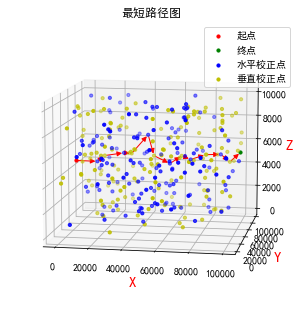

In [11]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
def plot_path(data,path):
    #### 起点 ####
    Xa = data[0][0]
    Ya = data[0][1]
    Za = data[0][2]
    #### 终点 ####
    Xb = data[n][0]
    Yb = data[n][1]
    Zb = data[n][2]
    #### 水平校正点 ####
    Xh = data[data[:,3]==0][:,0]
    Yh = data[data[:,3]==0][:,1]
    Zh = data[data[:,3]==0][:,2]
    #### 垂直校正点 ####
    Xv = data[data[:,3]==1][:,0]
    Yv = data[data[:,3]==1][:,1]
    Zv = data[data[:,3]==1][:,2]

    #### 绘制三维散点图 ####
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(Xa,Ya,Za, c='r', s=10, label='起点')
    ax.scatter(Xb,Yb,Zb, c='g', s=10, label='终点')
    ax.scatter(Xh,Yh,Zh, c='b', s=10, label='水平校正点')
    ax.scatter(Xv,Yv,Zv, c='y', s=10, label='垂直校正点')

    # 绘制图例
    ax.legend(loc='best')

    # 添加坐标轴(顺序是Z, Y, X)
    ax.set_zlabel('Z', fontdict={'size': 15, 'color': 'red'})
    ax.set_ylabel('Y', fontdict={'size': 15, 'color': 'red'})
    ax.set_xlabel('X', fontdict={'size': 15, 'color': 'red'})

    ax.view_init(elev=10., azim=-80)
    # 展示
    start = 0
    while start<len(path)-1:
        pre = path[start]
        next = path[start + 1]
        # ax.plot([data[pre][0], data[next][0]], [data[pre][1], data[next][1]],
        #             [data[pre][2], data[next][2]], color='red', alpha=0.8, lw=3)
        a = Arrow3D([data[pre][0], data[next][0]], [data[pre][1], data[next][1]],
                    [data[pre][2], data[next][2]], mutation_scale=10,
                    lw=1, arrowstyle="-|>", color="r")
        ax.add_artist(a)
        start = start+1
    plt.title("最短路径图")
    plt.draw()
    plt.show()
plot_path(data,path)